In [48]:
AUDIO_DIR = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/"
SAMPLE_RATE = 22050 # sample rate of the audio file
bit_depth = 16 # bit depth of the audio file
hop_length = 512
n_mfcc = 20 # number of MFCCs features
n_fft=1024, # window size
n_mels = 256 # number of mel bands to generate
win_length = None # window length



In [49]:
import glob
import random
import torch
import torchaudio
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

In [50]:

class AudioProcessor:
    def __init__(self, audio_dir, n_mfcc=n_mfcc):
        self.audio_dir = audio_dir
        self.n_mfcc = n_mfcc
        self.device = self.get_device()
        self.music_waves = []
        self.speech_waves = []
        self.mix_waves = []
        self.silence_waves = []
        self.load_audio_files()

    def load_audio_files(self):
        self.music_waves = glob.glob(self.audio_dir + "music_wav" + "/*.wav")
        self.speech_waves = glob.glob(self.audio_dir + "speech_wav" + "/*.wav")
        self.mix_waves = glob.glob(self.audio_dir + "Mix_wav" + "/*.wav")
        self.silence_waves = glob.glob(self.audio_dir + "silence_wav" + "/*.wav")

    def get_device(self):
        if torch.cuda.is_available():
            return "cuda"
        elif torch.backends.mps.is_built():
            return "mps"
        else:
            return "cpu"

    def preprocess(self, filepath, target_length=8000, sample_rate=SAMPLE_RATE):
        waveform, _ = torchaudio.load(filepath)
        waveform_length = waveform.size(1)

        if waveform_length < target_length:
            num_padding = target_length - waveform_length
            padding = torch.zeros(1, num_padding)
            waveform = torch.cat((waveform, padding), 1)
        elif waveform_length > target_length:
            waveform = waveform[:, :target_length]

        mfcc = torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=self.n_mfcc)(waveform)
        return mfcc

    def __len__(self):
        return len(self.music_waves) + len(self.speech_waves) + len(self.mix_waves) + len(self.silence_waves)

    def __getitem__(self, idx):
        if idx < len(self.music_waves):
            file_path = self.music_waves[idx]
            label = 0
        elif idx < len(self.music_waves) + len(self.speech_waves):
            file_path = self.speech_waves[idx - len(self.music_waves)]
            label = 1
        elif idx < len(self.music_waves) + len(self.speech_waves) + len(self.mix_waves):
            file_path = self.mix_waves[idx - len(self.music_waves) - len(self.speech_waves)]
            label = 2
        else:
            file_path = self.silence_waves[idx - len(self.music_waves) - len(self.speech_waves) - len(self.mix_waves)]
            label = 3

        waveform = self.preprocess(file_path)
        return waveform, label

    def play_audio_samples(self):
        music_sample = random.choice(self.music_waves)
        speech_sample = random.choice(self.speech_waves)
        mix_sample = random.choice(self.mix_waves)
        silence_sample = random.choice(self.silence_waves)

        print("Music sample:")
        ipd.display(ipd.Audio(music_sample))

        print("Speech sample:")
        ipd.display(ipd.Audio(speech_sample))

        print("Mix sample:")
        ipd.display(ipd.Audio(mix_sample))
        print("Silence sample:")
        ipd.display(ipd.Audio(silence_sample))

    def librosa_spectrogram(self, filepath):
        y, sr = librosa.load(filepath)
        S = librosa.feature.melspectrogram(y, sr=sr, n_mels=self.n_mfcc)
        log_S = librosa.power_to_db(S, ref=np.max)
        return log_S, sr

    def plot_single_spectrogram(self, axs, idx, mfcc_value, audio_file, audio_title):
        log_S, sr = self.librosa_spectrogram(audio_file)

        axs[idx, 0].set_title(f"Torchaudio {audio_title} MFCCs")
        img0 = axs[idx, 0].imshow(mfcc_value.squeeze().cpu().numpy().T, origin='lower', aspect='auto')
        axs[idx, 0].figure.colorbar(img0, ax=axs[idx, 0])

        axs[idx, 1].set_title(f"Librosa {audio_title} MFCCs")
        img1 = librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', ax=axs[idx, 1])
        axs[idx, 1].figure.colorbar(img1, ax=axs[idx, 1], format='%+2.0f dB')


    def plot_audio_spectrograms(self):
        audio_titles = ["Music", "Speech", "Mix", "Silence"]
        audio_files = [random.choice(self.music_waves), random.choice(self.speech_waves),
                       random.choice(self.mix_waves), random.choice(self.silence_waves)]
        audio_mfccs_values = [self.preprocess(file) for file in audio_files]

        fig, axs = plt.subplots(4, 2, figsize=(12, 16))

        for i, (mfcc_value, audio_file, audio_title) in enumerate(zip(audio_mfccs_values, audio_files, audio_titles)):
            self.plot_single_spectrogram(axs, i, mfcc_value, audio_file, audio_title)

        plt.tight_layout()
        plt.show()

    def process_and_visualize(self):
        self.play_audio_samples()
        self.plot_audio_spectrograms()



Music sample:


Speech sample:


Mix sample:


Silence sample:


<ipython-input-50-0140ebba5a48>:79: FutureWarning: Pass y=[-0.01925659 -0.00997925 -0.00170898 ...  0.01119995  0.0123291
  0.01281738] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=sr, n_mels=self.n_mfcc)
<ipython-input-50-0140ebba5a48>:79: FutureWarning: Pass y=[ 0.01467896  0.01464844  0.01470947 ... -0.01818848 -0.02304077
 -0.02749634] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=sr, n_mels=self.n_mfcc)
<ipython-input-50-0140ebba5a48>:79: FutureWarning: Pass y=[-0.09936523 -0.00515747  0.05014038 ... -0.0909729  -0.07577515
 -0.04019165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=sr, n_mels=self.n_mfcc)
<ipython-input-50-0140ebba5a48>:79: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args.

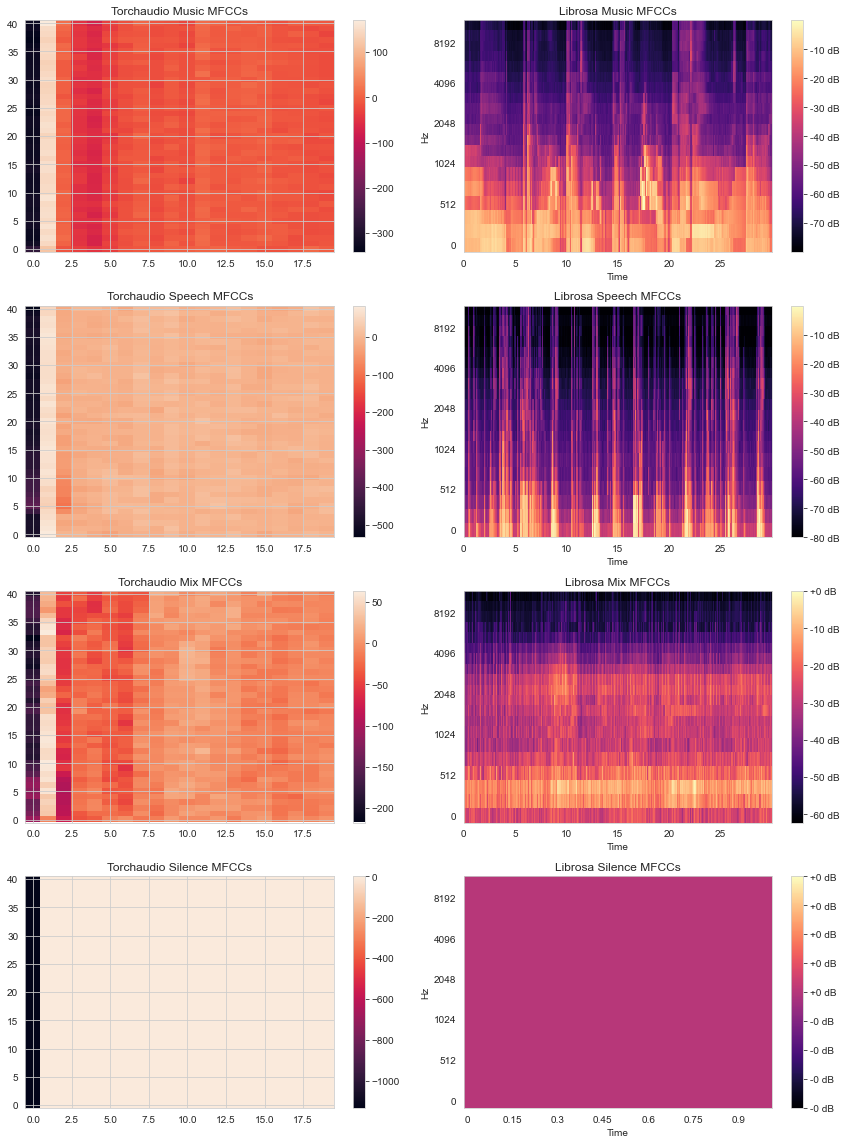

In [51]:
if __name__ == '__main__':
    AUDIO_DIR = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/"
    audio_processor = AudioProcessor(AUDIO_DIR)
    audio_processor.process_and_visualize()